In [4]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import eigsh
from tqdm import tqdm

import netket.operator as nkop
from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import Ising

import matplotlib.pyplot as plt

Total Nodes: 16


<Axes: >

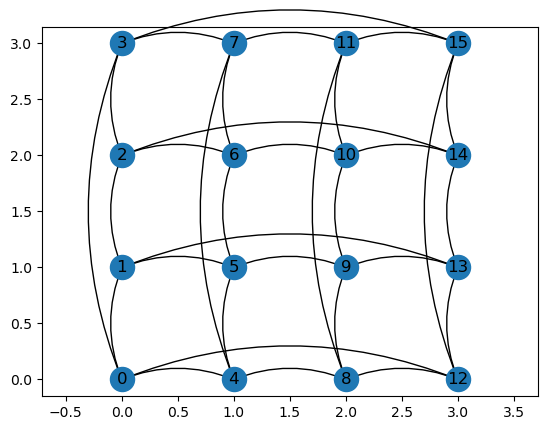

In [5]:
# set system parameters
SIDE_LENGTH = 4
DIMENSIONS = 2
PERIODIC_BOUNDARIES = True
J_COUPLING = -1.0

#### DRAW GRAPH ####

# n_dim=2 creates a Grid/Torus
graph = Hypercube(length=SIDE_LENGTH, n_dim=DIMENSIONS, pbc=PERIODIC_BOUNDARIES)
print(f"Total Nodes: {graph.n_nodes}")
graph.draw()

In [6]:
hilbert = Spin(s=0.5, N=graph.n_nodes)

def tfim_hamiltonian(hilbert, graph, h, J):
    return Ising(hilbert, graph, h=h, J=J)

def get_ground_state(hamiltonian):
    sp_mat = hamiltonian.to_sparse()
    # k=1 gives ground state
    # N=16 means matrix size 65,536 x 65,536. Sparse ED is still fast (~seconds).
    vals, vecs = eigsh(sp_mat, k=1, which="SA")
    psi = vecs[:, 0]

    # GAUGE FIXING:
    # Rotate so the largest amplitude is Real and Positive
    # CRITICAL for the finite difference derivative to work!
    first_idx = np.argmax(np.abs(psi))
    phase = np.angle(psi[first_idx])
    psi = psi * np.exp(-1j * phase)

    return vals[0], psi


def compute_fidelity_susceptibility(h_center, delta_h=1e-4):
    # get three ground states around point of interest
    ham_plus = tfim_hamiltonian(hilbert, graph, h=h_center + delta_h, J=J_COUPLING)
    ham_minus = tfim_hamiltonian(hilbert, graph, h=h_center - delta_h, J=J_COUPLING)
    ham_0 = tfim_hamiltonian(hilbert, graph, h=h_center, J=J_COUPLING)

    _, psi_plus = get_ground_state(ham_plus)
    _, psi_minus = get_ground_state(ham_minus)
    _, psi_0 = get_ground_state(ham_0)

    # Finite Difference Derivative (Central Difference)
    dpsi = (psi_plus - psi_minus) / (2 * delta_h)

    # geometric formula for susceptibility
    term1 = np.vdot(dpsi, dpsi).real
    term2 = np.abs(np.vdot(psi_0, dpsi))**2
    susceptibility = (term1 - term2)

    return susceptibility

# Test on one point
test_h = 2.0 # Higher field for 2D critical point (approx 3.04 for 2D Ising)
test_chi = compute_fidelity_susceptibility(test_h)
print(f"Test h={test_h}: Chi_F = {test_chi:.4f}")

Test h=2.0: Chi_F = 0.4629


In [7]:
print(f"{'='*60}")
print("CALCULATING FIDELITY SUSCEPTIBILITY")
print(f"System: TFIM (4x4 Grid, PBC={PERIODIC_BOUNDARIES})")
print(f"{'='*60}")

# Scan around the 2D critical point (~3.04)
h_values = np.linspace(2.0, 4.0, 50)

chi_results = []

for h_val in tqdm(h_values):
    # Using slightly larger delta_h for stability in larger Hilbert space
    val = compute_fidelity_susceptibility(h_val, delta_h=1e-4)
    chi_results.append(val)

chi_results = np.array(chi_results)
print("\nCalculation Complete.")

CALCULATING FIDELITY SUSCEPTIBILITY
System: TFIM (4x4 Grid, PBC=True)


100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Calculation Complete.


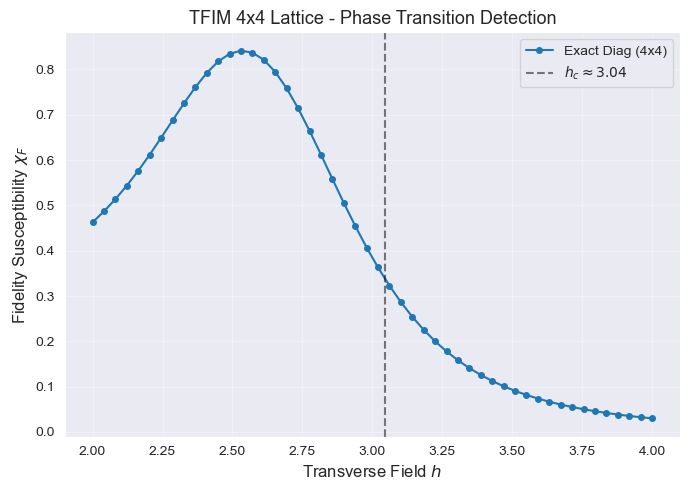

Reference data saved to: tfim_4x4_fidelity_ref.csv


In [20]:
plt.figure(figsize=(7, 5), dpi=100)

plt.plot(h_values, chi_results, marker="o", markersize=4, linestyle="-", color="tab:blue", label=r"Exact Diag (4x4)")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title(f"TFIM 4x4 Lattice - Phase Transition Detection", fontsize=13)

# Add theoretical line for 2D critical point
plt.axvline(3.044, color="k", linestyle="--", alpha=0.5, label=r"$h_c \approx 3.04$")

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# SAVE DATA
data = np.column_stack((h_values, chi_results))
file_name = f"tfim_4x4_fidelity_ref.csv"
header = "h,chi_F"
np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Reference data saved to: {file_name}")

In [22]:
# Stack h and chi into columns
data = np.column_stack((h_values, chi_results))

file_name = f"tfim_4x4_fidelity_ref.csv"
header = "h,chi_F"

# Save to CSV
np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Reference data saved to: {file_name}")

Reference data saved to: tfim_4x4_fidelity_ref.csv
